In [1]:
import numpy as np
import matplotlib.pyplot as plt

from optic.comm.modulation import modulateGray
from optic.dsp.core import pnorm, upsample, firFilter, pulseShape, signal_power
from optic.models.devices import mzm, iqm
from optic.utils import parameters, dBm2W
from optic.plot import eyediagram

# Canal Óptico

O canal de comunicação óptica é o resultado de diversas interações entre sinais ópticos e matéria. Esses efeitos podem ocorrer nas diversas seções de fibra óptica do link ou nos dispositivos atravessados pelo sinal óptico. 

O efeito mais fundamental para qualquer sistema de comunicação é atenuação, que reduz a potência do sinal ao longo do link como resultado de fenômenos de absorção e espalhamento. Devido à atenuação, os sinais transmitidos precisam ser amplificados periodicamente por amplificadores em linha, que inserem ruído e limitam o alcance do sistema.

Neste notebook não iremos abordar todos esses efeitos, mas apenas aqueles mais significativos para a modelagem de sistemas ópticos digitais coerentes.

### 3.2 Chromatic Dispersion

A dispersão do modo de polarização (*Polarization mode dispersion* - PMD) e a dispersão cromática (*Chromatic Dispersion* - CD) são dois efeitos lineares importantes que espalham símbolos ao longo do tempo e causam interferência. Eles geralmente são compensados no receptor usando usando tecnicas de processamento digital de sinais (DSP) Embora o PMD e o CD individualmente não limitem a capacidade, eles influenciam a complexidade do DSP do receptor, pois o CD pode exigir equalizadores estáticos muito longos e o PMD exige equalização adaptativa.

Neste tópico estamos interessados em transmitir informações através de fibras ópticas. A informação é transmitida apenas por pacotes de frequências, formando um padrão que viaja pela fibra com velocidade de grupo $v_g$

$$v_{g}=\left({\frac{d\beta}{d\omega}}\right)^{-1}$$

onde $\beta$ é a constante de propagação. Outro conceito necessário para entendermos esse fenômeno é a velocidade de fase $v_p$ de um sinal senoidal com frequência $\omega$ dado por

$$\ v_{p}={\frac{\omega}{\beta}}$$

Se a constante de propagação tiver uma dependência linear com a frequência, então $v_g = v_p$, qualquer grupo de frequências de propagação terá a mesma velocidade de grupo e os pulsos não serão distorcidos. É o caso, por exemplo, das ondas planas que viajam no espaço livre. Entretanto, em guias de onda práticos, a constante de propagação $\beta$ tem uma dependência não linear de $\omega$. Assim, diferentes componentes espectrais de um modo guiado se propagam com velocidades de grupo distintas, dando origem ao fenômeno conhecido como CD.

Se não for compensado, o CD amplia os pulsos de propagação e leva à interferência intersimbólica (ISI), como mostrado na figura abaixo que demostra o efeito do CD na propagação do sinal. CD espalha os pulsos no tempo, levando à interferência intersimbólica (ISI)

<br>
<center>
    <img src="https://i.postimg.cc/6pYm6pmx/Dispers-o.png">
</center>
<br>

**Referência:** Digital Coherent Optical Systems: Architecture and Algorithms

Considerando um guia de ondas sem perdas, os componentes de um campo elétrico ou magnético de frequência $\omega$ variam na direção de propagação no eixo $z$ de acordo com

$$E(z,\omega)=E(0,\omega)e^{-j\beta(\omega)z}$$

onde $\beta(w)$ é a constante de propagação em $\omega$. A mesma análise pode ser realizada para os componentes de frequência do espectro ${\tilde{A}}\left(z,\,0\right)$ do sinal $A(z, t)$, expandindo $\beta(\omega)$ na série de Taylor em torno da frequência angular da portadora $\omega_c$

$$\tilde{A}(z,\omega)=\tilde{A}(0,\omega)e^{-j\beta(\omega)z}$$
$$\tilde{A}(z,\omega)=\tilde{A}(0,\omega)e^{-\Big(j\beta_{0}+j\beta_{1}\Delta\omega+\frac{j\beta_{2}}{2}\Delta\omega^{2}+\ldots\Big)z}$$

Onde $\beta_i$ é a i-ésima derivada de $\beta$ em relação a $\omega$, e $\Delta\omega=\omega-\omega_{c}.$ O termo $e^{j\beta_{0}z}$ é uma mudança de fase. A multiplicação por $e^{j\beta_{1}\Delta\omega z}$ gera um deslocamento de tempo de um pulso não distorcido. 

A dispersão cromática está relacionada ao termo $e^{\frac{\beta_{2}}{2}\Delta\omega^{2}z}$. Para um observador viajando com o pulso, o espectro de um sinal corrompido por CD pode ser calculado como

$$\tilde{A}(z,\omega)=\tilde{A}(0,\omega)e^{-\frac{j\beta_{2}z}{2}\Delta\omega^{2}}$$

Podemos observar o efeito de disperção como um filtro passa tudo que modifica apenas a fase do nosso sinal, onde a amplitude e mantida constante. O parâmetro $\beta_2$ tem unidades de $s/m/[rad/s]$ e fornece a dispersão dos pulsos (em segundos) por unidade de comprimento de fibra (em metros) e por unidade de largura de banda espectral (em radianos por segundo). 

Na especificação de fibras ópticas, entretanto, a dispersão é geralmente quantificado pelo parâmetro de dispersão de velocidade de grupo (GVD), D, em unidades de $s/m^2$, ou melhor, em $ps/nm/km$. O parâmetro GVD indica a propagação do pulso (em picossegundos), por unidade de distância (em quilômetros), por unidade de largura de banda espectral (em nanômetros). Os parâmetros D e $\beta_2$ estão relacionados por

$$D=-{\frac{2\pi c}{\lambda^{2}}}\beta_{2},$$

Onde $c$ é a velocidade da luz no vácuo e $\lambda$ é o comprimento de onda operacional.

### Efeito da Dispersão

Caracteristicas da dispersão a partir da função de transferência do canal, desprezando as perdas.

In [28]:
# parâmetros da simulação
Fa = 100                                       # Frequência de amostragem
NFFT = 1024                                    # Tamanho da FFT
freq = Fa/NFFT * np.arange(-NFFT/2, NFFT/2)    # Intervalo de frequências
beta2 = 15e-6                                  # Parâmetro GVD
z = 150                                        # Distância de propagação [comprimento da fibra em metros]

$$H(\omega) = e^{j{\frac{\beta_{2}}{2}}\omega^{2}z}$$

In [29]:
H = np.exp(1j*0.5*beta2*z*(2*np.pi*freq)**2) # Função de transferência do canal

Observe que apenas a fase é alterada, a amplitude se mantém constante.

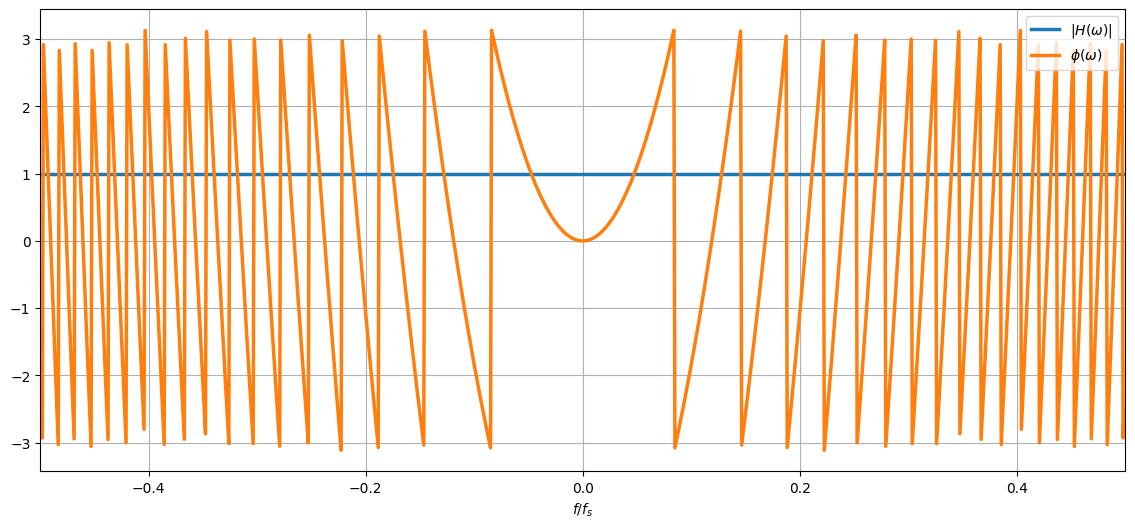

In [30]:
fig = plt.figure(figsize=(14, 6))
#plt.plot(freq/Fa, H.real, freq/Fa, H.imag)
plt.plot(freq/Fa, abs(H), freq/Fa, np.angle(H), linewidth=2.5)
plt.xlabel(r'$f/f_s$')
plt.xlim([-0.5, 0.5])
#plt.legend(['Real', 'Imag'], loc = 'upper right')
plt.legend([r'$|H(\omega)|$', r'$\phi(\omega)$'], loc = 'upper right')
plt.grid(True)

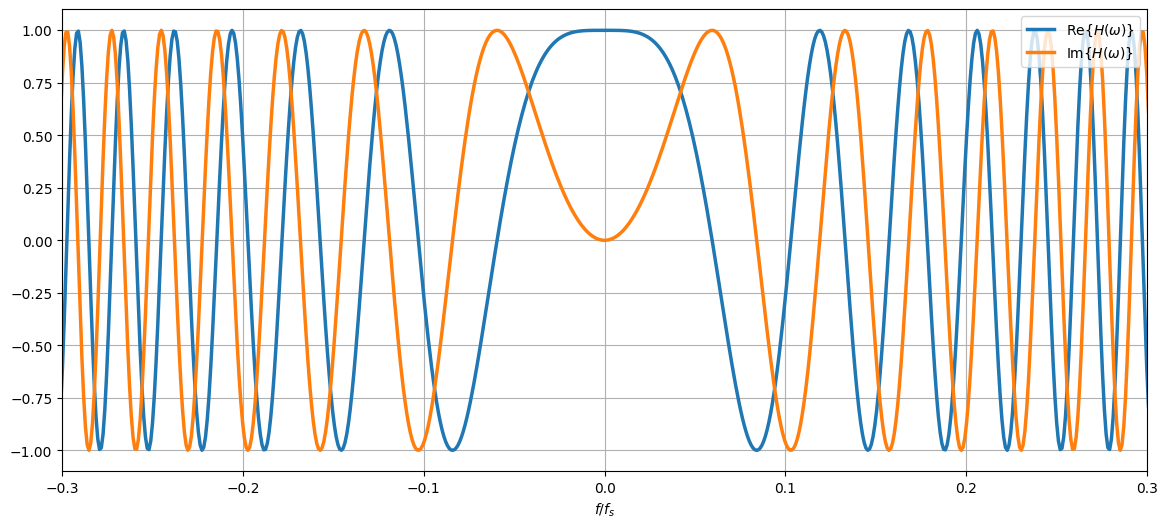

In [31]:
fig = plt.figure(figsize=(14, 6))
plt.plot(freq/Fa, H.real, freq/Fa, H.imag, linewidth=2.5)
plt.xlabel(r'$f/f_s$')
plt.xlim([-0.3, 0.3])
plt.legend(['Real', 'Imag'], loc = 'upper right')
plt.legend([r'Re{$H(\omega)$}', r'Im{$H(\omega)$}'], loc = 'upper right')
plt.grid(True)

### Simulação de transmissão 10Gbaud 4-PAM com dispersão

In [23]:
# Parâmetros da simulação.
M = 4                   # Ordem da modulação
constType = 'pam'       # Esquema de modulação
pulseType = 'nrz'       # Pulso a ser utilizado
Rs = 10e9               # Taxa de símbolos [símbolo/s]
Ts = 1/Rs               # Período de símbolo em segundos
SpS = 32                # Amostras por símbolo
Fa = 1/(Ts/SpS)         # Frequência de amostragem do sinal [amostras/segundo]
Ta = 1/Fa               # Período de amostragem
Ncoeff = 1024           # Número de coeficientes do filtro RC
alpha = 0.05            # Rolloff

λ = 1550e-9     # comprimento de onda
c = 299792458   # velocidade da luz [m/s](vacuum)

# parâmetros do MZM
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# Parâmetros da fibra
D = 18e-6                        # Parâmetro de dispersão ps/(nm*km) - SMF28
beta2 = -(D*λ**2)/(2*np.pi*c)    # GVD
z = 70e3                         # Comprimento do link [m]

# Parâmetros do receptor
Rd  = 0.85                       # responsividade em A/W

Distância sobre a qual um pulso se espalha ou dispersa ao viajar através da fibra.

$$LD = \frac{T_{s}^2}{|\beta_2|}$$

In [24]:
LD = (Ts**2)/abs(beta2)
print('Comprimento de dispersão (m): %f' %(LD))

Comprimento de dispersão (m): 435576.729636


In [25]:
# gera uma sequência de bits pseudo-aleatórios que chegam ao transmissor
bitsTx = np.random.randint(2, size = int(1e5*np.log2(M)))

# Gera o mapeamento dos bits para símbolos M-PAM
symbTx = modulateGray(bitsTx, M, constType)    
symbTx = pnorm(symbTx) # power normalization

symbolsUp = upsample(symbTx, SpS)

# seleciona o pulso desejado.
if pulseType == "nrz" or pulseType == "rect":
    pulse = pulseShape(pulseType, SpS)
elif pulseType == "rc":
    pulse = pulseShape(pulseType, SpS, Ncoeff, alpha, Ts)

pulse = pulse/max(abs(pulse))
# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)

# adiciona ruído gaussiano ao sinal em banda base
samples = sigTx.size    # amostras
σ2 = 0.0005             # variância
μ  = 0                  # média
σ  = np.sqrt(σ2)        # devio padrão

noise = np.random.normal(μ, σ, samples)
sigTx = sigTx + noise

# Laser power
Pi_dBm = -16        # potência óptica do laser na entrada do MZM em dBm
Pi = dBm2W(Pi_dBm)  # converter de dBm para W

# optical modulation
Ai = np.sqrt(Pi)
sigTxo = mzm(Ai, 0.25*sigTx.real, paramMZM)

print('Potência média do sinal óptico modulado [mW]: %.3f mW'%(signal_power(sigTxo)/1e-3))
print('Potência média do sinal óptico modulado [dBm]: %.3f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

Potência média do sinal óptico modulado [mW]: 0.013 mW
Potência média do sinal óptico modulado [dBm]: -19.009 dBm


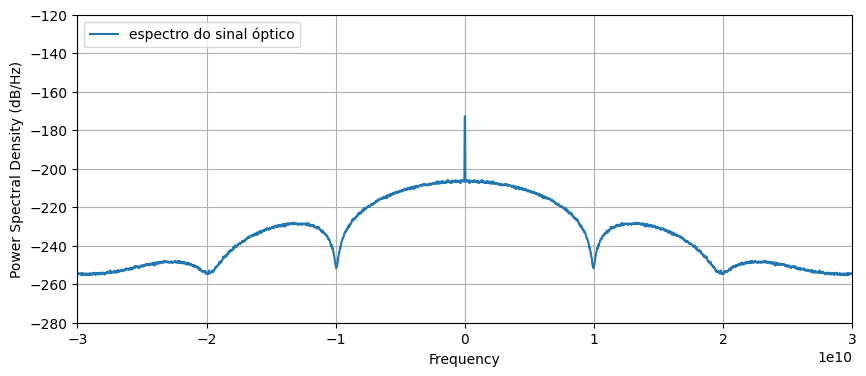

In [26]:
# plot psd
plt.figure(figsize=(10, 4))
plt.xlim(-3*Rs, 3*Rs)
plt.ylim(-280, -120)
plt.psd(np.abs(sigTxo)**2, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'espectro do sinal óptico')
plt.legend(loc='upper left');

### Transmitindo o sinal na fibra

In [27]:
# transformada de fourier do sinal óptico
sigTxoFFT = np.fft.fftshift(np.fft.fft(sigTxo))/len(sigTxo)
# define um intervalo de frequências 
freq = np.fft.fftshift(np.fft.fftfreq(len(sigTxoFFT), Ta))
# função de transferência do canal desprezando as perdas
H = np.exp(1j*0.5*beta2*z*(2*np.pi*freq)**2)

# obtém a resposta ao impulso do canal
sigRxFFT = H * sigTxoFFT
# sinal óptico recebido no domínio do tempo
sigRxo = np.fft.ifft(sigRxFFT)*len(sigTxo)

t = np.arange(0, symbTx.size)*(Ta/1e-9)

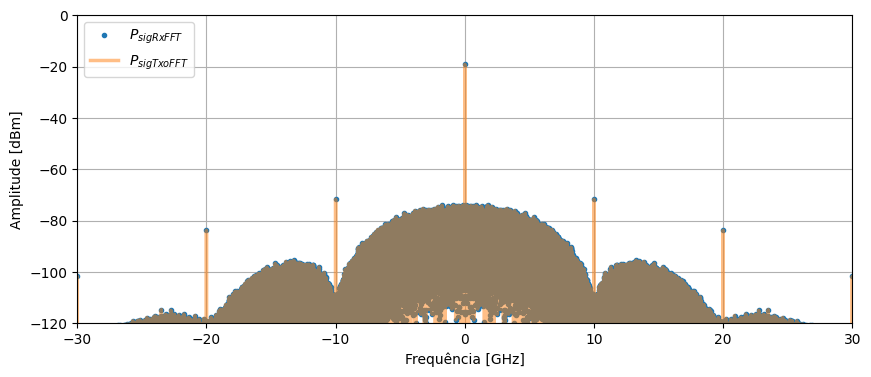

In [28]:
plt.figure(None, figsize=(10, 4))

plt.plot(1e-9*freq, 10*np.log10(1e3*np.abs(sigRxFFT)**2), '.', label = '$P_{sigRxFFT}$')
plt.plot(1e-9*freq, 10*np.log10(1e3*np.abs(sigTxoFFT)**2), alpha = 0.5, linewidth=2.5, label = '$P_{sigTxoFFT}$')
plt.ylabel('Amplitude [dBm]')
plt.xlabel('Frequência [GHz]')
plt.xlim(-3e-9*Rs, 3e-9*Rs)
plt.ylim(-120,0)
plt.grid(True)
plt.legend(loc = 'upper left');

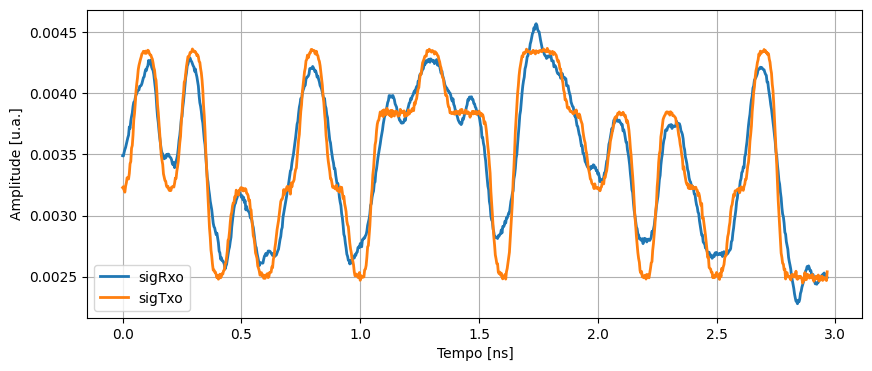

In [29]:
plt.figure(None, figsize=(10, 4))

plt.plot(t[0:950], np.abs(sigRxo[0:950]), linewidth=2, label = 'sigRxo')
plt.plot(t[0:950], np.abs(sigTxo[0:950]), linewidth=2, label = 'sigTxo')
plt.xlabel('Tempo [ns]')
plt.ylabel('Amplitude [u.a.]')
plt.grid(True)
plt.legend(loc = 'lower left');

E possível notar que o sinal recebido se encontra distorcido em relação ao sinal transmitido, veja que quando maior o enlace maior será a distância sobre a qual o pulso se espalha no domínio do tempo, além disso quanto maior a nossa taxa de transmissão mais nocivo será o efeito de dispersão sobre o sinal, visto que a sinalização terá um tempo ainda menor para transmitir um determinado pulso.

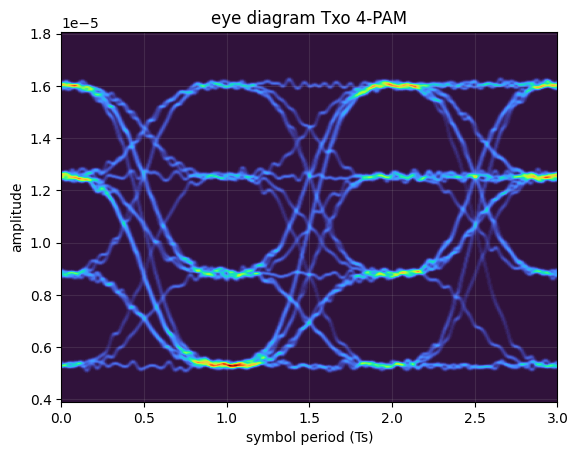

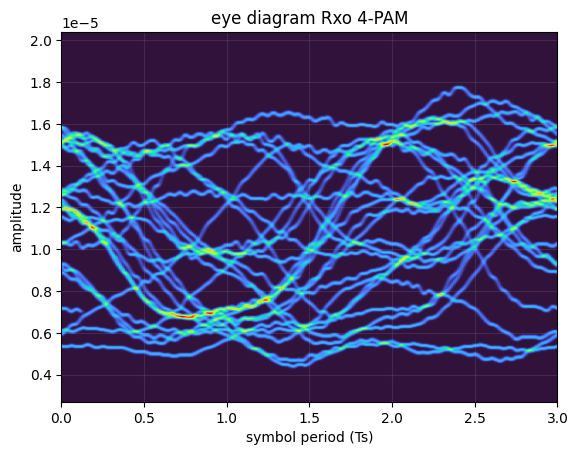

In [31]:
# diagrama de olho para o sinal óptico modulado 
NsamplesTx = sigTxo.size
figureTx = eyediagram(Rd*np.abs(sigTxo)**2, NsamplesTx, SpS, plotlabel = 'Txo '+str(M)+'-'+str(constType).upper(), ptype='fancy')

# diagrama de olho após a fibra
NsamplesRx = sigRxo.size
figureTx = eyediagram(Rd*np.abs(sigRxo)**2, NsamplesRx, SpS, plotlabel = 'Rxo '+str(M)+'-'+str(constType).upper(), ptype='fancy')

### 3.4 Attenuation

A atenuação reduz a potência de um sinal óptico que se propaga através da fibra. Está diretamente relacionado ao alcance do sistema, pois os receptores possuem um nível mínimo de potência para o qual podem recuperar os dados transmitidos de forma satisfatória. 

A atenuação ocorre devido a diversos fenômenos, como a absorção de material, que é intrínseca ao material utilizado na produção da fibra e suas impurezas, dispersão de luz, imperfeições na geometria do guia de ondas e curvaturas na fibra. Por causa da atenuação, a potência de entrada $P_{i − dBm}$ e a potência de saída $P_{o − dBm}$ de uma fibra óptica, em dBm, estão relacionados por:


$$P_{o-\mathrm{dBm}}=P_{i-\mathrm{dBm}}-\alpha_{\mathrm{dB/km}}L_{\mathrm{km}}$$

Onde $L_{km}$ é o comprimento da fibra em $km$ e $\alpha_{\mathrm{dB/km}}$ é o coeficiente de atenuação dado em $dB/km$. Também é possível descrever a mesma relação em termos de unidades de potência linear, com $P_o$ e $P_i$ expressos em $mW$ (ou $W$)

$$P_{o-\mathrm{mW}}=P_{i-\mathrm{mW}}e^{-\alpha_{\mathrm{Np/km}}L_{\mathrm{km}}}$$

onde $\alpha_{\mathrm{Np/km}}$ é o coeficiente de atenuação dado em $N_p/km$. Os coeficientes de atenuação $\alpha$ em $dB/km$ e em $N_p/km$ estão relacionados por

$$\alpha_{\mathrm{dB/km}}=(10\mathrm{log}_{10}e)\:\alpha_{\mathrm{Np/km}}=4.34\alpha_{\mathrm{Np/km}}$$

O perfil de atenuação de uma fibra óptica mostra a dependência da atenuação no comprimento de onda. Possui três janelas principais de baixa atenuação que são normalmente usadas para comunicações ópticas, em torno de 850, 1310 e 1550 $nm$. O aumento acentuado da atenuação em comprimentos de onda inferiores a 850 $nm$ é causado principalmente pelo [espalhamento Rayleigh](https://pt.wikipedia.org/wiki/Dispers%C3%A3o_de_Rayleigh) devido a flutuações aleatórias no índice de refração da sílica.

Do outro lado do espectro, o alto aumento na atenuação em comprimentos de onda superiores a 1600 $nm$ aparece devido à absorção na região infravermelha. Outro fenômeno dominante é a absorção em torno de 1390 $nm$ causada por íons OH- residuais na sílica. Este pico divide a segunda e a terceira janela, centradas em 1310 (com $\alpha_{dB/km}$ ≈ 0,3 $dB/km$) $nm$ e 1550 $nm$ (com $\alpha_{dB/km}$ ≈ 0,2 $dB/km$).

A terceira janela, em torno de 1550 $nm$, apresenta uma atenuação de aproximadamente 0,2 $dB/km$, que é consideravelmente menor que a das outras duas, sendo, portanto, amplamente utilizada para transmissão de longa distância.

Considerando as perdas (atenuação) na fibra teremos a seguinte função de transferência:

$$H(\omega) = e^{j{\frac{\beta_{2}}{2}}\omega^{2}z}e^{\frac{-\alpha z}{2}}$$

onde $\alpha$ é o parâmetro de atenuação em $dB/km$

In [39]:
αdB = 0.20                  # dB/Km
α   = 1e-3*αdB/4.343        # 1/m
H  = np.exp(1j*0.5*beta2*z*(2*np.pi*freq)**2)*np.exp(-0.5*α*z)

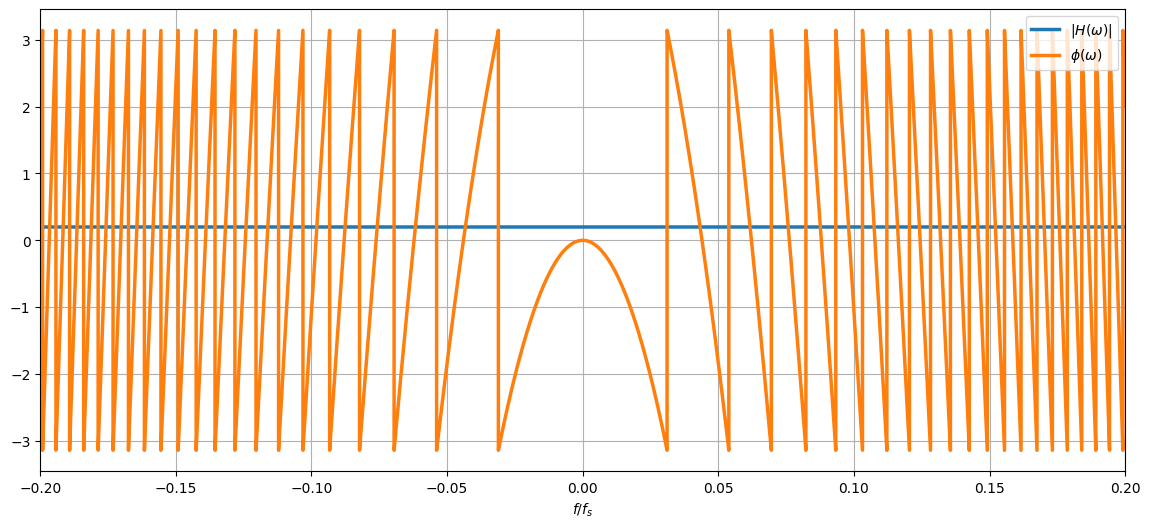

In [40]:
fig = plt.figure(figsize=(14, 6))
#plt.plot(freq/Fa, H.real, freq/Fa, H.imag)
plt.plot(freq/Fa, abs(H), freq/Fa, np.angle(H), linewidth=2.5)
plt.xlabel(r'$f/f_s$')
plt.xlim([-0.2, 0.2])
#plt.legend(['Real', 'Imag'], loc = 'upper right')
plt.legend([r'$|H(\omega)|$', r'$\phi(\omega)$'], loc = 'upper right')
plt.grid(True)

In [2]:
def linearFiberChannel(sigTxo, paramCh):
    """ simulação da propagação do sinal por um canal de fibra linear

    Args:
        sigTxo (np.array):   sinal óptico modulado.
        param (object):      objeto com parâmetros físicos de simulação do canal óptico.
    Return:
        sigRxo (np.array):   sinal de saída da fibra.
    """
    L   = paramCh.L                     # comprimento do enlace [m]
    α   = 1e-3*paramCh.alpha/4.343      # coeficiente de perdas [1/m]
    D   = paramCh.D                     # parâmetro da dispersão cromática
    Fa  = paramCh.Fa                    # frequência de amostragem do sinal [amostras/s]
    
    # definindo constantes
    λ = 1550e-9     # comprimento de onda
    c = 299792458   # velocidade da luz [m/s](vacuum)
    
    β2 = -(D*λ**2)/(2*np.pi*c) # GVD
    
    NFFT = len(sigTxo)
    sigTxoFFT = np.fft.fftshift(np.fft.fft(sigTxo))/NFFT
    # define um intervalo de frequências
    freq = np.fft.fftshift(np.fft.fftfreq(len(sigTxoFFT), 1/Fa))
    
    # função de trânsferência do canal considerando as perdas
    H  = np.exp(1j*0.5*β2*L*(2*np.pi*freq)**2)*np.exp(-0.5*α*L)
    # obtém a resposta ao impulso do canal
    sigRxFFT = H * sigTxoFFT
    # sinal óptico recebido no domínio do tempo
    sigRxo = np.fft.ifft(sigRxFFT)*NFFT
    
    return sigRxo

### Simulação de Transmissão 10GBaud 16-QAM com dispersão e perdas

In [7]:
# Parâmetros da simulação.
M = 16                  # Ordem da modulação
constType = 'qam'       # Esquema de modulação
pulseType = 'rc'        # Pulso a ser utilizado
Rs = 10e9               # Taxa de símbolos [símbolo/s]
Ts = 1/Rs               # Período de símbolo em segundos
SpS = 32                # Amostras por símbolo
Fa = 1/(Ts/SpS)         # Frequência de amostragem do sinal [amostras/segundo]
Ta = 1/Fa               # Período de amostragem
Ncoeff = 1024           # Número de coeficientes do filtro RC
alpha = 0.05            # Rolloff

# parâmetros do IQM
paramIQM = parameters()
paramIQM.Vπ = 2 
paramIQM.Vb = -paramIQM.Vπ

# Parâmetros da fibra
paramFiber = parameters()
paramFiber.L = 70e3         # comprimento do enlace [m]
paramFiber.alpha = 0.16     # coeficiente de perdas [dB/Km]
paramFiber.D = 18e-6        # parâmetro de dispersão
paramFiber.Fa = Fa          # Frequência de amostragem do sinal [amostras/segundo]

In [8]:
# gera uma sequência de bits pseudo-aleatórios que chegam ao transmissor
bitsTx = np.random.randint(2, size = int(1e4*np.log2(M)))

# Gera o mapeamento dos bits para símbolos M-PAM
symbTx = modulateGray(bitsTx, M, constType)    
symbTx = pnorm(symbTx) # power normalization

symbolsUp = upsample(symbTx, SpS)

# seleciona o pulso desejado.
if pulseType == "nrz" or pulseType == "rect":
    pulse = pulseShape(pulseType, SpS)
elif pulseType == "rc":
    pulse = pulseShape(pulseType, SpS, Ncoeff, alpha, Ts)

pulse = pulse/max(abs(pulse))
# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)

# adiciona ruído gaussiano ao sinal em banda base
samples = sigTx.size    # amostras
σ2 = 0.0005             # variância
μ  = 0                  # média
σ  = np.sqrt(σ2)        # devio padrão

noise = np.random.normal(μ, σ, samples)
sigTx = sigTx + noise

# Laser power
Pi = 100e-3  # potência óptica do laser na entrada do IQM

# optical modulation
Ai = np.sqrt(Pi)
sigTxo = iqm(Ai, 0.1*paramIQM.Vπ*sigTx, paramIQM)

print('Potência média do sinal óptico modulado [mW]: %.3f mW'%(signal_power(sigTxo)/1e-3))
print('Potência média do sinal óptico modulado [dBm]: %.3f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

Potência média do sinal óptico modulado [mW]: 1.207 mW
Potência média do sinal óptico modulado [dBm]: 0.819 dBm


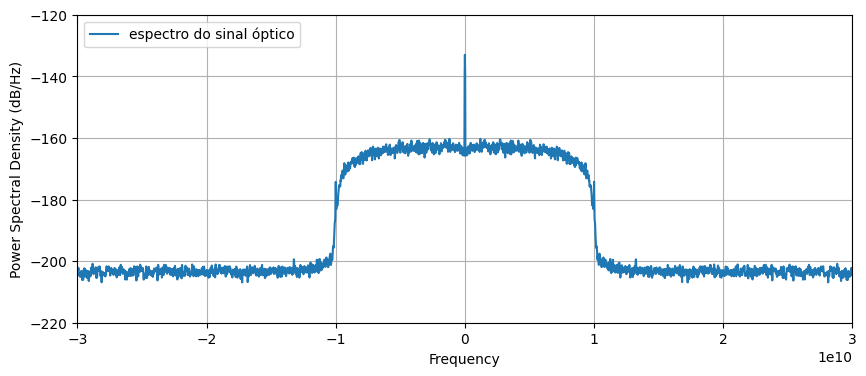

In [11]:
# plot psd
plt.figure(figsize=(10, 4))
plt.xlim(-3*Rs, 3*Rs)
plt.ylim(-220, -120)
plt.psd(np.abs(sigTxo)**2, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'espectro do sinal óptico')
plt.legend(loc='upper left');

### Transmitindo o sinal na fibra

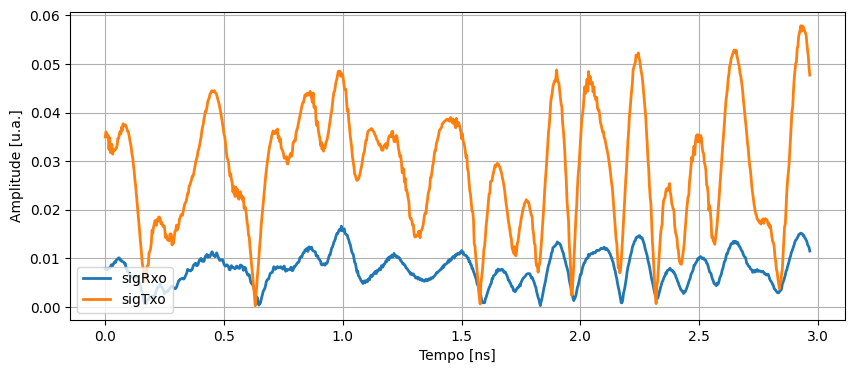

In [10]:
sigRxo = linearFiberChannel(sigTxo, paramFiber)

t = np.arange(0, symbTx.size)*(Ta/1e-9)

plt.figure(None, figsize=(10, 4))
plt.plot(t[0:950], np.abs(sigRxo[0:950]), linewidth=2, label = 'sigRxo')
plt.plot(t[0:950], np.abs(sigTxo[0:950]), linewidth=2, label = 'sigTxo')
plt.xlabel('Tempo [ns]')
plt.ylabel('Amplitude [u.a.]')
plt.grid(True)
plt.legend(loc = 'lower left');

Observe que além da distorção causada pela disperção também ouve a redução de potência do sinal óptico durante a propagação na fibra. 

### OSNR (*optical signal-to-noise*)

A medida típica para o acúmulo de ruído em sistemas de fibra óptica é a relação sinal-ruído óptico (OSNR), que pode ser relacionado ao SNR assumindo pulsos em formato de Nyquist com largura de banda mínima e transmissão e recepção em uma orientação de polarização

$${\mathrm{SNR}}={\frac{E_{s}}{N_{0}}}={\frac{P_{\mathrm{signal}}}{G_{\mathrm{ASE}}R_{s}}}={\frac{2B_{\mathrm{ref}}}{R_{s}}}{\frac{P_{\mathrm{signal}}}{P_{\mathrm{ASE}}}}={\frac{2B_{\mathrm{ref}}}{R_{s}}}\mathrm{OSNR}$$

onde a largura de banda do sinal é assumida como sendo a taxa de símbolo $R_s$ e a densidade do espectro de potência de ruído em um $G_{ASE}$ de polarização. Denotamos $E_s = P_{sinal}$ como a potência do sinal após um receptor casado, e $N_0$ como a potência do ruído após o receptor casado.

Em sistemas com multiplexação de polarização, o sinal $P$ é dividido igualmente entre as duas orientações de polarização e, portanto,

$$SNR = {\frac{2B_{\mathrm{ref}}}{R_{s}}}\mathrm{OSNR}$$

Em uma polarização a largura de banda de referência $B_{\mathrm{ref}}$ é comumente considerada como 12.5 GHz. Observe que esta relação entre OSNR e SNR depende apenas da taxa de bits da informação sendo independente de utilizarmos multiplexação de polarização ou não.

# Referências 

[1] Digital Coherent Optical Systems, Architecture and Algorithms